<a href="https://colab.research.google.com/github/ABD-01/Face-Unlock/blob/master/facenet/FaceNet_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from collections import OrderedDict
import collections
from tqdm.notebook import tqdm
from PIL import Image
import PIL
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from glob import glob
 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Subset
import torch.optim as optim

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder, VisionDataset
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
def seed_init():
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_init()
# ref : https://discuss.pytorch.org/t/random-seed-initialization/7854/19

In [5]:
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/Datasets/LFWDataset.py
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/model.py
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/facenet/triplet_loss.py
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/facenet/eval.py

!wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
!wget http://vis-www.cs.umass.edu/lfw/peopleDevTrain.txt
!wget http://vis-www.cs.umass.edu/lfw/peopleDevTest.txt
!wget http://vis-www.cs.umass.edu/lfw/pairs.txt
!wget http://vis-www.cs.umass.edu/lfw/people.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-names.txt

--2021-06-02 06:05:08--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/Datasets/LFWDataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6947 (6.8K) [text/plain]
Saving to: ‘LFWDataset.py’

LFWDataset.py       100%[===================>]   6.78K  --.-KB/s    in 0s      

2021-06-02 06:05:08 (63.8 MB/s) - ‘LFWDataset.py’ saved [6947/6947]

--2021-06-02 06:05:09--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6616 (6.5K) [text/plain]
Saving to:

In [7]:
from LFWDataset import LFW_People, LFW_Pairs
from model import *
import triplet_loss
from eval import calculate_metrics, evaluate

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [33]:
MEAN = torch.Tensor([0.5929, 0.4496, 0.3654])
STD = torch.Tensor([0.2287, 0.1959, 0.1876])
process = transforms.Compose([
    transforms.CenterCrop((105,105)),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

In [1]:
dataset = LFW_People(
    root = 'lfw_funneled',
    people_path = 'drive/MyDrive/lfw-dataset/lfw-names.txt',
    transform = process
)
dataset


Getting images: 100%|██████████| 5749/5749 [00:03<00:00, 1691.12it/s]
Dataset LFW_People
    Number of datapoints: 13233
    Root location: lfw_funneled
    StandardTransform
Transform: Compose(
               CenterCrop(size=(105, 105))
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=tensor([0.5929, 0.4496, 0.3654]), std=tensor([0.2287, 0.1959, 0.1876]))
           )



In [ ]:
lfw_pairs = LFW_Pairs("lfw_funneled", "pairs.txt", process)
print(lfw_pairs)
test_loader = DataLoader(lfw_pairs,batch_size=100)
psame = np.asarray(lfw_pairs.is_same_list)
psame.shape

Getting pairs: 100%|██████████| 6000/6000 [00:00<00:00, 60172.79it/s]


Dataset LFW_Pairs
    Number of datapoints: 6000
    Root location: lfw_funneled
    StandardTransform
Transform: Compose(
               CenterCrop(size=(105, 105))
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=tensor([0.5929, 0.4496, 0.3654]), std=tensor([0.2287, 0.1959, 0.1876]))
           )


(6000,)

In [ ]:
loader = DataLoader(dataset, batch_size=100, num_workers=1)

In [ ]:
mean = 0.0
for images, _ in tqdm(loader, desc="Calculating Mean"):
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in tqdm(loader, desc="Calculating Std"):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*224*224))

#ref: https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/2

In [ ]:
print("Mean=", mean, "Std=", std)

Mean= tensor([0.5939, 0.4505, 0.3663]) Std= tensor([0.2279, 0.1949, 0.1867])


In [63]:
invNorm = transforms.Compose([transforms.Normalize(mean=0, std=1/STD),
                              transforms.Normalize(mean=-MEAN, std=1),
                               ])
# ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/4

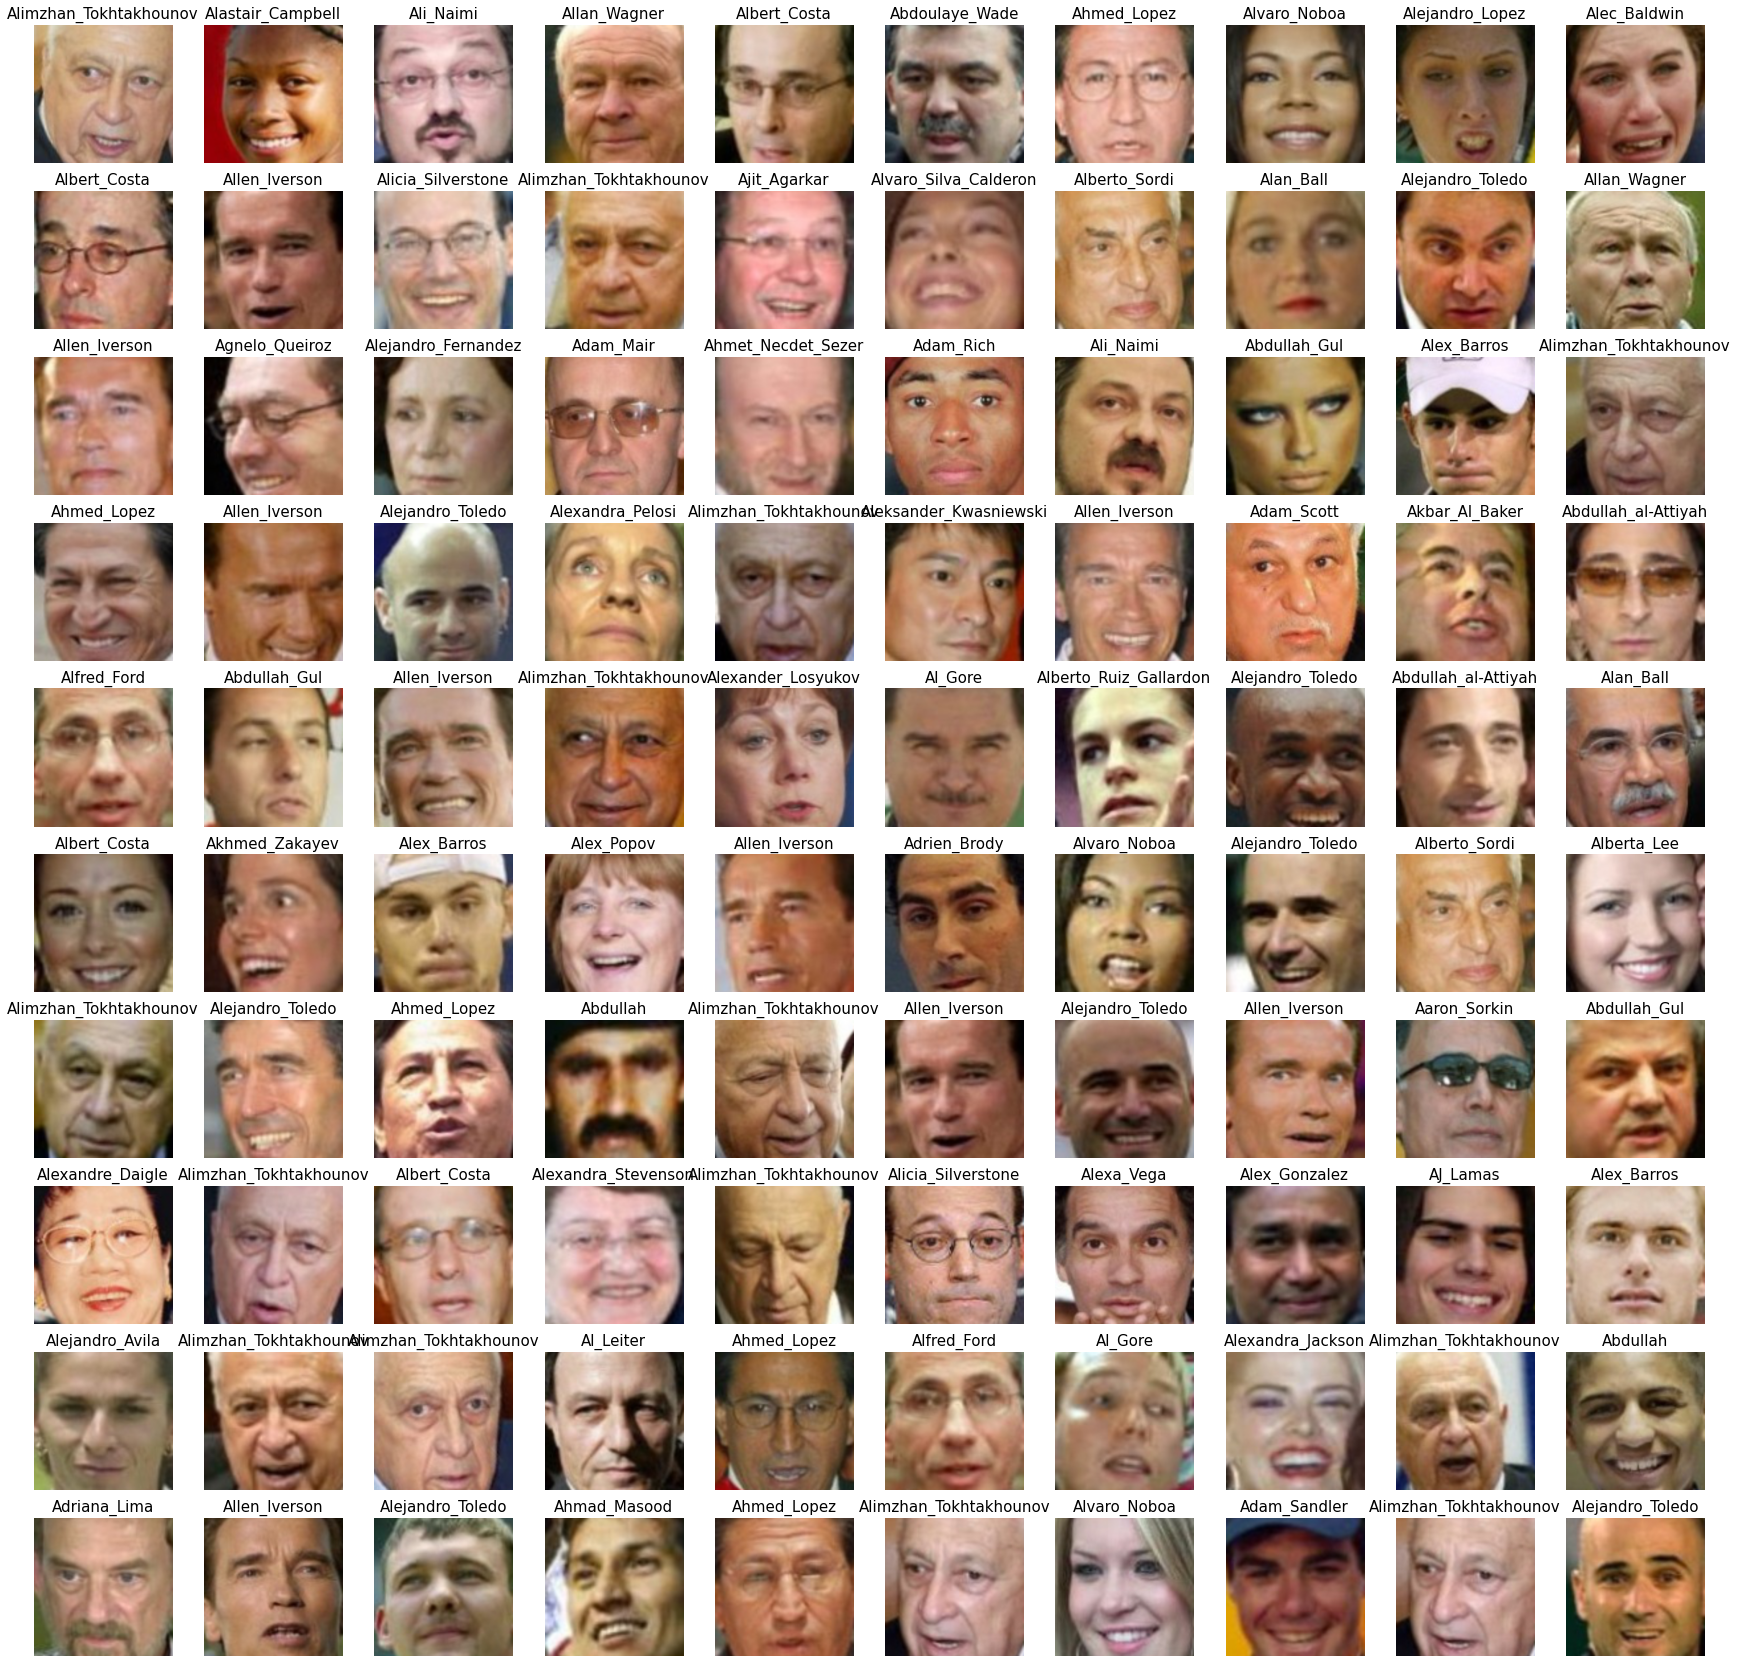

In [4]:
_, axxr = plt.subplots(10,10, figsize=(30,30))
for ax in axxr.flatten():
    idx = random.randint(0, 1000)
    img = dataset[idx]
    ax.imshow(invNorm(img[0]).permute(1,2,0))
    ax.title.set_text(dataset.ids[img[1]])
    ax.title.set_size(15)
    ax.axis('off')
plt.show()

# W&B

In [12]:
!pip install wandb

     |████████████████████████████████| 1.8MB 2.9MB/s 
     |████████████████████████████████| 174kB 20.2MB/s 
     |████████████████████████████████| 133kB 18.9MB/s 
     |████████████████████████████████| 102kB 8.4MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=18016065ad43dee552bd0f65516d4777a727aabe3d215a4bf84398ec23a15a6b
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=473e6e498b949092ead211a0ec019af129a405480992062e7b18856c9e8f50af
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [13]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
import wandb

In [ ]:
# 1. Start a new run
wandb.init(project="Face-Unlock")

In [ ]:
# 2. Save model inputs and hyperparameters
config = wandb.config
config.batch_size = 100
config.epochs = 200
config.learning_rate = 0.005
config.scheduler = "ReduceLROnPlateau()"
config.fc_layer_size = 128
config.train_dataset = "LFW"
config.architechture = "ResNet44"

In [11]:
resnet = ResNet(layers=[3,4,4,3], num_classes=config.fc_layer_size, bottleneck=True)
resnet.to(device)

ResNet44(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (conv): Conv2d(64, 256, kernel_s

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
count_parameters(resnet)

21535936

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr = config.learning_rate)

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=0.00001, verbose=True)

In [ ]:
wandb.watch(resnet, criterion="tripletloss", log='all')

In [18]:
epochs_loss =[]

In [ ]:
def evaluate(distances, labels, roc_curve=False):
    # mask = np.logical_not(np.eye(labels.shape[0], dtype='bool'))
    # Psame = labels[mask]
    # distances = distances[mask]
    thresholds = np.arange(0,4,0.01)
    num_thresholds = len(thresholds)
    vals = np.zeros(num_thresholds)
    fars = np.zeros(num_thresholds)
    youdens = np.zeros(num_thresholds)
    for idx, threshold in tqdm(enumerate(thresholds)):
        vals[idx], fars[idx], _, _ = calculate_metrics(threshold, distances, labels)
        youdens[idx] = vals[idx] - fars[idx] # sensitivity + specificity — 1
    best_threshold_idx = np.argmax(youdens) 

    if roc_curve:
        fig, ax = plt.subplots()
        ax.plot(fars, vals, marker = '.', c='r')
        ax.plot([0,1], [0,1], linestyle='--', label="random")
        ax.scatter(fars[best_threshold_idx], vals[best_threshold_idx], c='black', label='Optimal Threshold')
        ax.grid()
        ax.title.set_text('ROC Curve')
        ax.set_xlabel('False Accept Rate (FAR)')
        ax.set_ylabel('True Accept Rate (VAL)')
        ax.legend()
        wandb.log({"ROC Curve": fig}, commit=False)


    true_accept_rate, false_accept_rate, precision, accuracy = \
         calculate_metrics(thresholds[best_threshold_idx], distances, labels)

    return thresholds[best_threshold_idx], true_accept_rate, false_accept_rate, precision, accuracy 

In [ ]:
def validate(network):
    network.eval()
    distances = []
    with torch.no_grad():
        for pair1, pair2, _ in tqdm(test_loader):
            embds1 = network(pair1.to(device)).cpu()
            embds2 = network(pair2.to(device)).cpu()
            distance = (embds1 - embds2).norm(p=2, dim=1)
            distances.append(distance)
    distances = torch.cat(distances)
    best_threshold, tar, far, precision, accuracy  = evaluate(distances.detach().numpy(), psame, True)
    wandb.log({
        "Recall": tar,
        "Precision": precision,
        "Accuracy": accuracy,
        "FAR":far
    })
    network.train()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
resnet.train()
for epoch in range(config.epochs):
    loader = DataLoader(dataset, batch_size=config.batch_size, num_workers=1, shuffle=True)
    try:
        epoch_loss = 0
        for step, (images, labels) in enumerate(loader):
            print(f"Epoch: {epoch:02d}, Step: {step:02d},", end=" ")
            start_time = time.time()
            embds = resnet(images.to(device)).to('cpu')
            optimizer.zero_grad()

            loss = triplet_loss.batch_hard_triplet_loss(labels, embds, margin=1)
            epoch_loss += loss.item()
            wandb.log({"loss": loss.item()})
            print(f"Loss: {loss.item():.3f}, ", end=" ")

            loss.backward()
            optimizer.step()
            
            current_time = time.time()
            print("Time: {:.4f}s".format(current_time-start_time))
        epoch_loss = epoch_loss/config.batch_size
        wandb.log({"epoch_loss": epoch_loss,
                    "lr":optimizer.state_dict()["param_groups"][0]['lr']},
                    commit="False")
        scheduler.step(epoch_loss)
        epochs_loss.append(epoch_loss)
        validate(resnet)
    except RuntimeError as re:
        device = torch.device('cpu')
        torch.save(resnet.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/resnet44_lfw_checkpoint{epoch+1}.pth")
        resnet.cpu()
        print(f"{re}: Shifted to CPU")

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epochs_loss, label="EpochLoss")
plt.grid(alpha=0.5)
plt.title("Loss Curve")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/EpochLoss_resnet44", dpi=200)
plt.show()

In [ ]:
torch.save(resnet.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/resnet44_lfw.pth")

In [20]:
resnet.eval()

ResNet44(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (conv): Conv2d(64, 256, kernel_s

In [25]:
torch.onnx.export(resnet, torch.zeros(100,3,224,224), "resnet44.onnx")
wandb.save("resnet44.onnx")

['/content/wandb/run-20210602_062652-2r527f0c/files/resnet44.onnx']

# Evaluate

In [35]:
lfw_pairs = LFW_Pairs("lfw_funneled", "pairs.txt", process)
lfw_pairs

Getting pairs: 100%|██████████| 6000/6000 [00:00<00:00, 60775.71it/s]

Dataset LFW_Pairs
    Number of datapoints: 6000
    Root location: lfw_funneled
    StandardTransform
Transform: Compose(
               CenterCrop(size=(105, 105))
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=tensor([0.5929, 0.4496, 0.3654]), std=tensor([0.2287, 0.1959, 0.1876]))
           )

In [36]:
loader = DataLoader(lfw_pairs,batch_size=100)

In [39]:
features = []
distances = []
with torch.no_grad():
    
    for pair1, pair2, _ in tqdm(loader):
        embds1 = resnet(pair1.to(device)).cpu()
        embds2 = resnet(pair2.to(device)).cpu()
        features.append((embds1, embds2))
        distance = (embds1 - embds2).norm(p=2, dim=1)
        distances.append(distance)

In [40]:
features[0][0].shape, distances[0].shape

(torch.Size([100, 128]), torch.Size([100]))

In [41]:
feats = []
for feature in features:
    feats.append( torch.stack(feature) )

In [ ]:
feats = torch.cat(feats, dim=1)

In [ ]:
feats.shape

torch.Size([2, 6000, 128])

In [ ]:
dists = (feats[0] -feats[1]).norm(p=2,dim=1)
dists.shape

torch.Size([6000])

In [42]:
distances = torch.cat(distances)
distances.shape

torch.Size([6000])

In [43]:
distances.min(), distances.mean(), distances.max()

(tensor(0.3327), tensor(1.3192), tensor(1.9351))

In [44]:
psame = np.asarray(lfw_pairs.is_same_list)
psame.shape

(6000,)

In [58]:
val, far, precision, accuracy = calculate_metrics(1.32, distances.detach().numpy(), psame)

print(f"True accept rate = {val}")
print(f"False Accept Rate = {far}")
print(f"Precision = {precision}")
print(f"Accuracy = {accuracy}")

True accept rate = 0.35433333333333333
False Accept Rate = 0.23466666666666666
Precision = 0.6015846066779853
Accuracy = 0.5598333333333333



400it [00:00, 4699.66it/s]


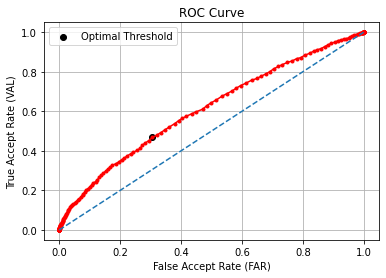

In [46]:
best_threshold, tar, far, precision, accuracy  = evaluate(distances.detach().numpy(), psame, True)

In [59]:
print("Best Threshold: {}\nTrue Acceptance: {:.3f}\nFalse Acceptance: {:.3f}\nPrecision: {:.3f}\nAccuracy: {:.3f}".format(best_threshold, tar, far, precision, accuracy ))

Best Threshold: 1.36
True Acceptance: 0.459
False Acceptance: 0.332
Precision: 0.580
Accuracy: 0.564


In [48]:
!wget https://raw.githubusercontent.com/tamerthamoqa/facenet-pytorch-glint360k/63a18012427311e7df0773e045ada88b32fb854c/validate_on_LFW.py

--2021-06-02 07:29:25--  https://raw.githubusercontent.com/tamerthamoqa/facenet-pytorch-glint360k/63a18012427311e7df0773e045ada88b32fb854c/validate_on_LFW.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8721 (8.5K) [text/plain]
Saving to: ‘validate_on_LFW.py’

validate_on_LFW.py  100%[===================>]   8.52K  --.-KB/s    in 0s      

2021-06-02 07:29:25 (61.8 MB/s) - ‘validate_on_LFW.py’ saved [8721/8721]



In [49]:
from validate_on_LFW import evaluate_lfw

In [60]:
true_positive_rate, false_positive_rate, precision, recall, accuracy, roc_auc, best_distances, \
        tar, far = evaluate_lfw(
            distances=distances.detach().numpy(),
            labels=psame,
            far_target=1e-1
        )
# Print statistics and add to log
print("Accuracy on LFW: {:.4f}+-{:.4f}\nPrecision {:.4f}+-{:.4f}\nRecall {:.4f}+-{:.4f}\n"
        "ROC Area Under Curve: {:.4f}\nBest distance threshold: {:.2f}+-{:.2f}\n"
        "TAR: {:.4f}+-{:.4f} @ FAR: {:.4f}".format(
            np.mean(accuracy),
            np.std(accuracy),
            np.mean(precision),
            np.std(precision),
            np.mean(recall),
            np.std(recall),
            roc_auc,
            np.mean(best_distances),
            np.std(best_distances),
            np.mean(tar),
            np.std(tar),
            np.mean(far)
        ))

Accuracy on LFW: 0.5617+-0.0131
Precision 0.5790+-0.0143
Recall 0.4503+-0.0391
ROC Area Under Curve: 0.5821
Best distance threshold: 1.36+-0.01
TAR: 0.1833+-0.0261 @ FAR: 0.1003


# Validating

In [51]:
preds = distances.detach().numpy()<best_threshold

In [52]:
pdiff = np.logical_not(psame)

true_accepts  = np.sum(np.logical_and(preds, psame))
false_accepts = np.sum(np.logical_and(preds, pdiff))
false_rejects = np.sum(np.logical_and(np.logical_not(preds), psame))
true_rejects  = np.sum(np.logical_and(np.logical_not(preds), pdiff))

true_accepts, false_accepts, false_rejects, true_rejects

(1404, 918, 1596, 2082)

In [53]:
psame.sum(), pdiff.sum()

(3000, 3000)

In [54]:
val = true_accepts  / (psame.sum() + 1e-16) # sensitivity, recall
far = false_accepts / (pdiff.sum() + 1e-16) # (1-specificity)

val, far

(0.468, 0.306)

In [55]:
false_accepts = np.logical_and(preds, pdiff)

In [56]:
false_accepts.sum()

918

In [61]:
false_accept_idxs =  (false_accepts == 1).nonzero()[0]
false_accept_idxs.shape

(918,)

777


<Figure size 432x288 with 0 Axes>

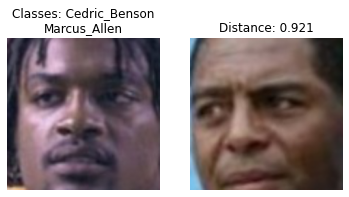

916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

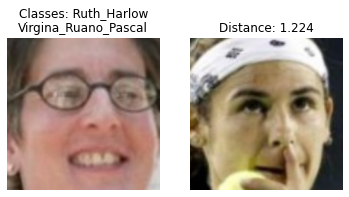

115


<Figure size 432x288 with 0 Axes>

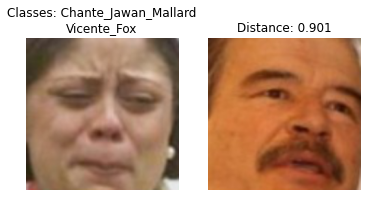

755


<Figure size 432x288 with 0 Axes>

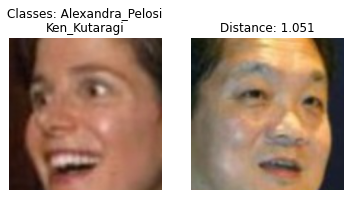

709


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

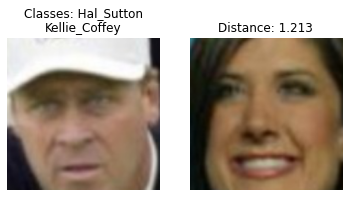

847


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

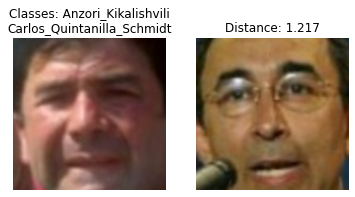

431


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

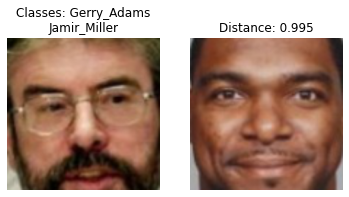

448

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

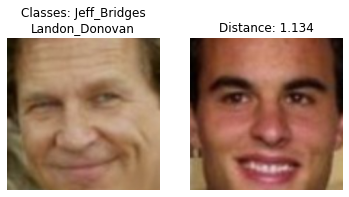

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


850


<Figure size 432x288 with 0 Axes>

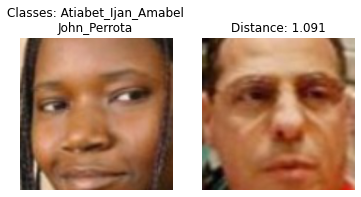

99


<Figure size 432x288 with 0 Axes>

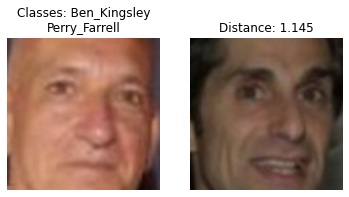

177


<Figure size 432x288 with 0 Axes>

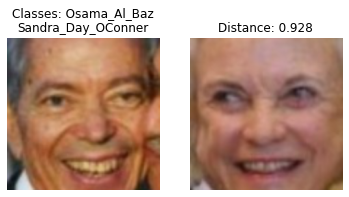

755


<Figure size 432x288 with 0 Axes>

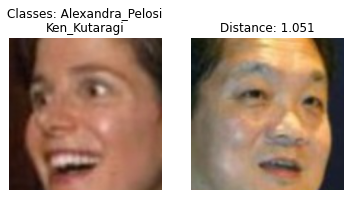

797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

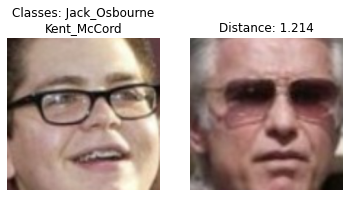

659


<Figure size 432x288 with 0 Axes>

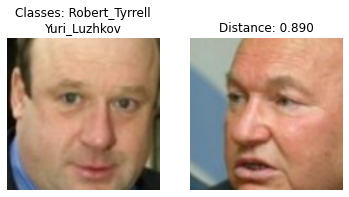

147


<Figure size 432x288 with 0 Axes>

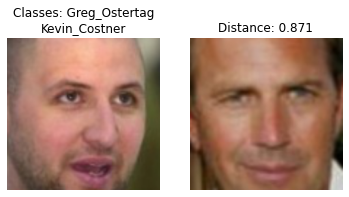

910


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

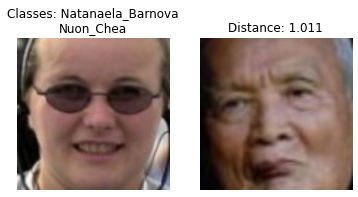

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


423


<Figure size 432x288 with 0 Axes>

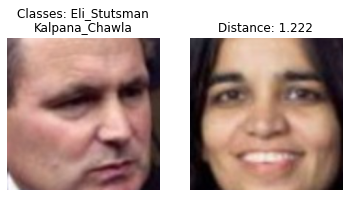

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


288


<Figure size 432x288 with 0 Axes>

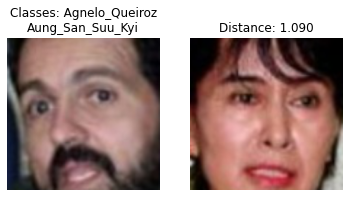

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


265


<Figure size 432x288 with 0 Axes>

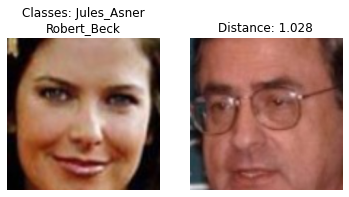

697


<Figure size 432x288 with 0 Axes>

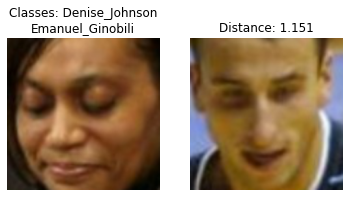

639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

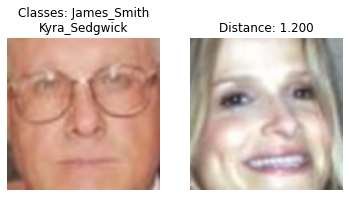

544


<Figure size 432x288 with 0 Axes>

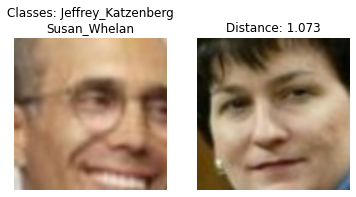

543


<Figure size 432x288 with 0 Axes>

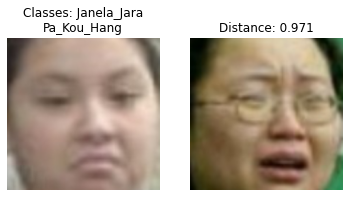

714


<Figure size 432x288 with 0 Axes>

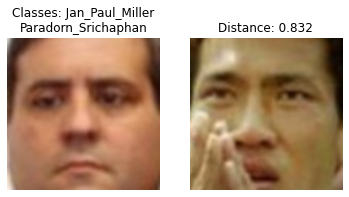

244


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

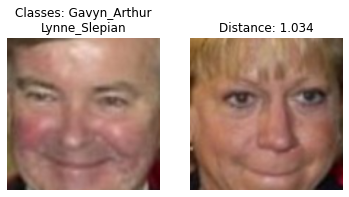

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


151


<Figure size 432x288 with 0 Axes>

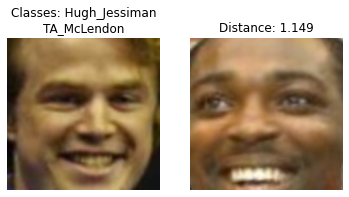

675


<Figure size 432x288 with 0 Axes>

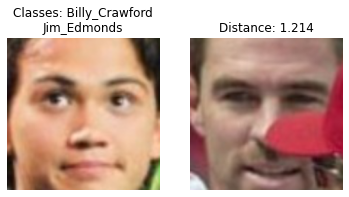

510


<Figure size 432x288 with 0 Axes>

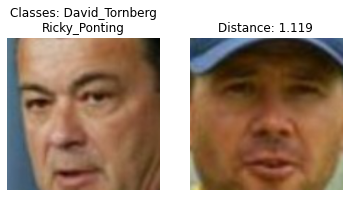

459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

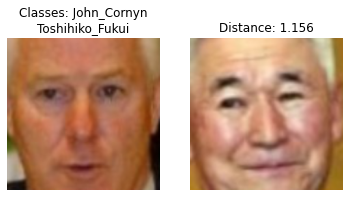

882


<Figure size 432x288 with 0 Axes>

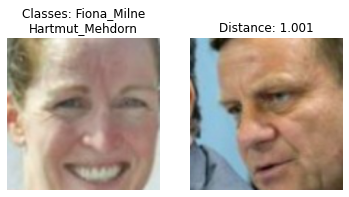

In [64]:
for idx in np.random.randint(0,false_accept_idxs.shape[0], size=30):
    print(idx)
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)

    idx1= false_accept_idxs[idx]
    img1, img2, same =  lfw_pairs[idx1]

    i1.imshow(invNorm(img1).permute(1,2,0))
    i2.imshow(invNorm(img2).permute(1,2,0))
    # i1.title.set_text(f'Classes: {path_list[idx1].split("/")[-2]}\n{path_list[idx2].split("/")[-2]}')
    i1.title.set_text('Classes: {}'.format("\n".join(lfw_pairs.ids[idx1])))
    i2.title.set_text(f'Distance: {distances[idx1]:.3f}')
    i1.axis('off')
    i2.axis('off')

    plt.show()

In [65]:
false_rejects = np.logical_and(np.logical_not(preds), psame)

In [66]:
false_rejects.sum()

1596

In [67]:
false_rejects_idxs =  (false_rejects == 1).nonzero()[0]
false_rejects_idxs.shape

(1596,)

1207


<Figure size 432x288 with 0 Axes>

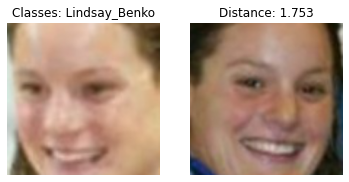

28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

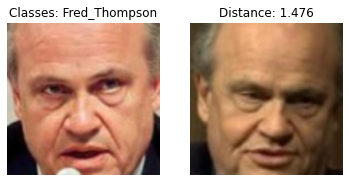

802


<Figure size 432x288 with 0 Axes>

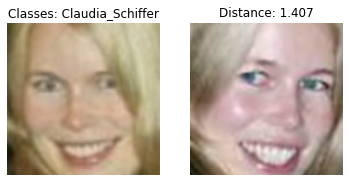

128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

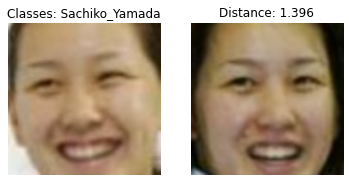

128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

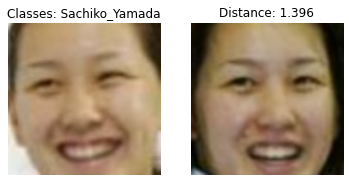

1077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

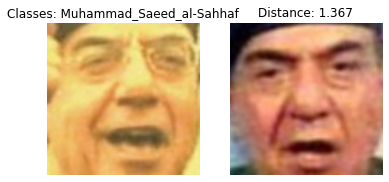

1574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

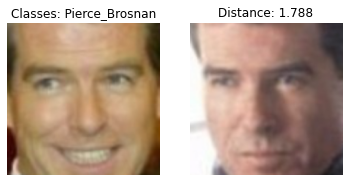

1512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

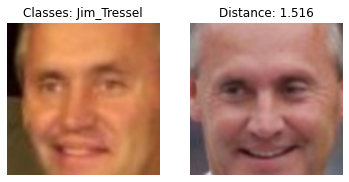

756


<Figure size 432x288 with 0 Axes>

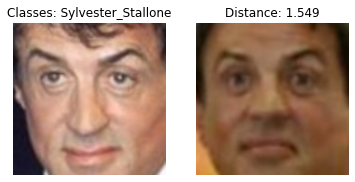

273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

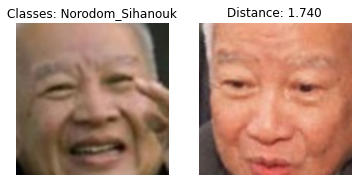

335


<Figure size 432x288 with 0 Axes>

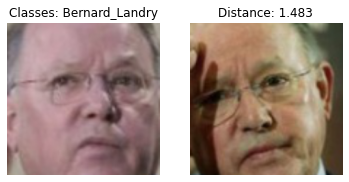

388


<Figure size 432x288 with 0 Axes>

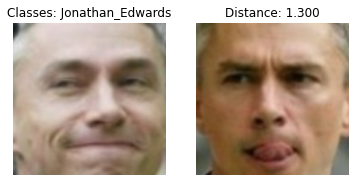

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1066


<Figure size 432x288 with 0 Axes>

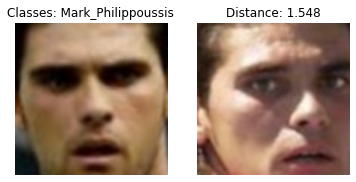

1466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

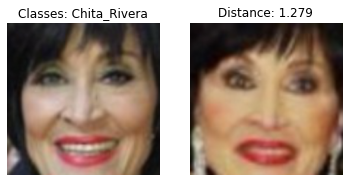

543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

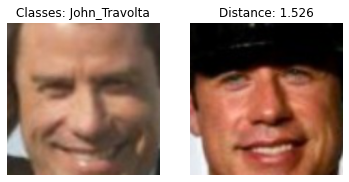

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


888


<Figure size 432x288 with 0 Axes>

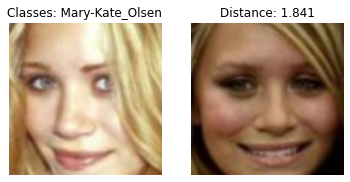

257


<Figure size 432x288 with 0 Axes>

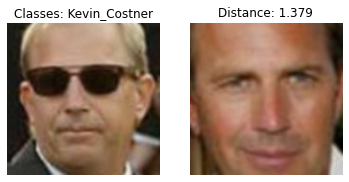

1345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

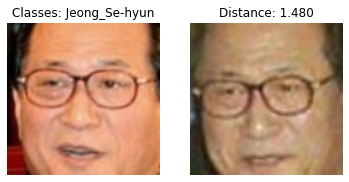

57


<Figure size 432x288 with 0 Axes>

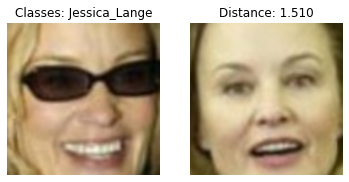

291


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

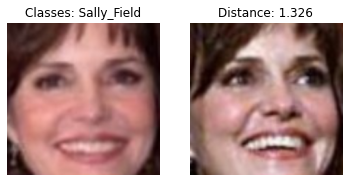

1143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

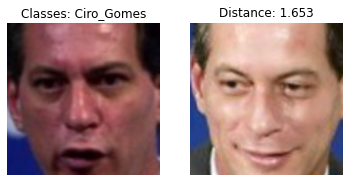

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


779


<Figure size 432x288 with 0 Axes>

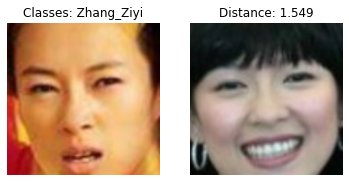

430


<Figure size 432x288 with 0 Axes>

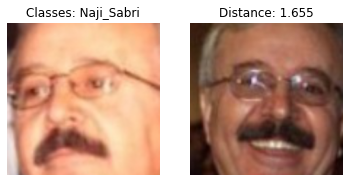

1106


<Figure size 432x288 with 0 Axes>

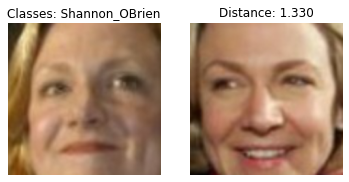

91


<Figure size 432x288 with 0 Axes>

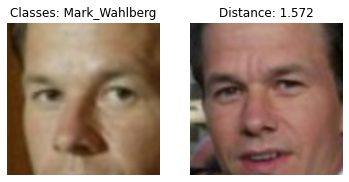

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


398


<Figure size 432x288 with 0 Axes>

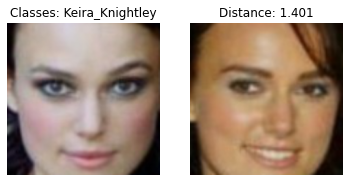

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


611


<Figure size 432x288 with 0 Axes>

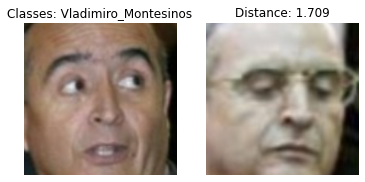

1589


<Figure size 432x288 with 0 Axes>

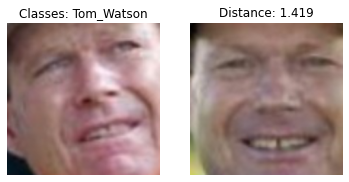

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


908


<Figure size 432x288 with 0 Axes>

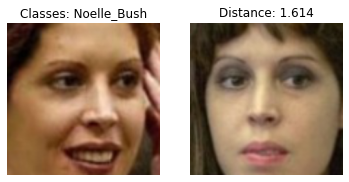

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


633


<Figure size 432x288 with 0 Axes>

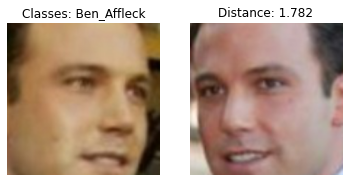

In [68]:
for idx in np.random.randint(0,false_rejects_idxs.shape[0], size=30):
    print(idx)
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)

    idx1= false_rejects_idxs[idx]
    img1, img2, same =  lfw_pairs[idx1]

    i1.imshow(invNorm(img1).permute(1,2,0))
    i2.imshow(invNorm(img2).permute(1,2,0))
    i1.title.set_text('Classes: {}'.format(lfw_pairs.ids[idx1]))
    i2.title.set_text(f'Distance: {distances[idx1]:.3f}')
    i1.axis('off')
    i2.axis('off')

    plt.show()

# Sweep

In [ ]:
import wandb

In [ ]:
sweep_config = {
    'method': 'random' # grid, random, bayes
    }

In [ ]:
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }
sweep_config['metric'] = metric

In [ ]:
parameter_dict = {
    'fc_layer_size': {
        'values': [128]
    },
    'learning_rate': {
        'values': [0.005, 0.001,  0.0005, 0.0001, 0.00005, 0.00001]
    },
    'batch_size': {
        'values': [64, 100, 200]
    },
    'epochs': {
        'values': [100, 200]
    }
}
sweep_config['parameters'] = parameter_dict

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [64, 100, 200]},
                'epochs': {'values': [100, 200]},
                'fc_layer_size': {'values': [128]},
                'learning_rate': {'values': [0.005,
                                             0.001,
                                             0.0005,
                                             0.0001,
                                             5e-05,
                                             1e-05]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project='Face-Unlock', )

Create sweep with ID: mzun8o0a
Sweep URL: https://wandb.ai/abd1/Face-Unlock/sweeps/mzun8o0a


In [ ]:
lfw_pairs = LFW_Pairs("lfw_funneled", "pairs.txt", process)
lfw_pairs

Getting pairs: 100%|██████████| 6000/6000 [00:00<00:00, 76957.82it/s]

Dataset LFW_Pairs
    Number of datapoints: 6000
    Root location: lfw_funneled
    StandardTransform
Transform: Compose(
               CenterCrop(size=(105, 105))
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=tensor([0.5929, 0.4496, 0.3654]), std=tensor([0.2287, 0.1959, 0.1876]))
           )

In [ ]:
loader = DataLoader(lfw_pairs,batch_size=100)

In [ ]:
psame = np.asarray(lfw_pairs.is_same_list)
psame.shape

(6000,)

In [ ]:
def evaluate(distances, labels, roc_curve=False):
    # mask = np.logical_not(np.eye(labels.shape[0], dtype='bool'))
    # Psame = labels[mask]
    # distances = distances[mask]
    thresholds = np.arange(0,4,0.01)
    num_thresholds = len(thresholds)
    vals = np.zeros(num_thresholds)
    fars = np.zeros(num_thresholds)
    youdens = np.zeros(num_thresholds)
    for idx, threshold in tqdm(enumerate(thresholds)):
        vals[idx], fars[idx], _, _ = calculate_metrics(threshold, distances, labels)
        youdens[idx] = vals[idx] - fars[idx] # sensitivity + specificity — 1
    best_threshold_idx = np.argmax(youdens) 

    if roc_curve:
        fig, ax = plt.subplots()
        ax.plot(fars, vals, marker = '.', c='r')
        ax.plot([0,1], [0,1], linestyle='--', label="random")
        ax.scatter(fars[best_threshold_idx], vals[best_threshold_idx], c='black', label='Optimal Threshold')
        ax.grid()
        ax.title('ROC Curve')
        ax.xlabel('False Accept Rate (FAR)')
        ax.ylabel('True Accept Rate (VAL)')
        ax.legend()
        wandb.log({"ROC Curve": fig}, commit=False)


    true_accept_rate, false_accept_rate, precision, accuracy = \
         calculate_metrics(thresholds[best_threshold_idx], distances, labels)

    return thresholds[best_threshold_idx], true_accept_rate, false_accept_rate, precision, accuracy 

In [ ]:
def validate(network):
    network.eval()
    distances = []
    with torch.no_grad():
        for pair1, pair2, _ in tqdm(loader):
            embds1 = network(pair1.to(device)).cpu()
            embds2 = network(pair2.to(device)).cpu()
            distance = (embds1 - embds2).norm(p=2, dim=1)
            distances.append(distance)
    distances = torch.cat(distances)
    best_threshold, tar, far, precision, accuracy  = evaluate(distances.detach().numpy(), psame, True)
    wandb.log({
        "Recall": tar,
        "Precision": precision,
        "Accuracy": accuracy,
        "FAR":far
    })
    network.train()

In [ ]:
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'batch_size': 100,
        'epochs': 100,

        'fc_layer_size': 128,
        'learning_rate': 0.001,
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # define model
    network = ResNet18(num_classes=config.fc_layer_size)
    network.to(device)
    
    # optimizer
    optimizer = optim.Adam(network.parameters(), lr=config.learning_rate)

    network.train()
    for epoch in range(config.epochs):
        epoch_loss = 0
        loader = DataLoader(dataset, batch_size=config.batch_size, num_workers=1, shuffle=True)
        for images, labels in loader:
            optimizer.zero_grad()
            embds = network(images.to(device)).to("cpu")
            loss = triplet_loss.batch_hard_triplet_loss(labels, embds, margin=1)
            epoch_loss += loss.item()
            wandb.log({"loss": loss.item()})
            loss.backward()
            optimizer.step()
        wandb.log({"epoch_loss": epoch_loss / config.batch_size}, commit=False)
        validate(network)

In [ ]:
wandb.agent(sweep_id, train, count=10)

In [ ]:
wandb.finish()